# Main Notebook

File to perform experiments

## Imports

In [1]:
import os
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
import tensorflow as tf

from models.GaussianProcess import GaussianProcess
from acquisition_functions.UseMO import usemo_acq
from acquisition_functions.MES import mes_acq, basic_mes_acq
from acquisition_functions.PESMO import pesmo_acq
from acquisition_functions.MESMO import mesmo_acq
from arguments.arguments import MainArguments

from MOObenchmark import MOOackley, MOOexponential, MOOquadratic_ackley, MOOnnHeartNeurons
from utils.calc_pareto import get_pareto_undominated_by, getSetfromFront

from models.MOOEvaluationProblem import MOOEvaluationProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.optimize import minimize

2023-06-12 17:15:57.775951: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 17:15:57.816070: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 17:15:57.816523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 17:15:58.401053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Algorithm Arguments

In [2]:
d = 5 # input dimensions
    
seed = 0
np.random.seed(seed)

## iterations of the main algorithm
total_iter = 40
## iterations taken randomly at the beggining
initial_iter = 1

## bound of the inputs definition
### with the current implementations all the input dimensions must have the same bounds, 
### but this can be changed
lower_bound = 10
upper_bound = 1000

lowerBounds = [lower_bound]*d
upperBounds = [upper_bound]*d


## Evaluation

In [3]:
## Evaluation function definition
O = 2
C = 0

def evaluation(x):
    return MOOnnHeartNeurons(x)

This cell below gets the real pareto in two ways: with a grid and with a cheap optimizer (genetic algorithm) and plots both of them. These results are used in test problems as the actual pareto front. Although, to obtain these paretos many evaluations of the function are needed, so it has no sense running it in a costly black box problem.

In addition this is only prepared to plot a d=1, O=2 problem. We could visualize any problem, but the visualization get a lot more abstract and more plots are needed. If this is interesting I could do it.

Therefore I set the code below as text.

N = 1_001
X = np.linspace(lower_bound,upper_bound,N)
Z = np.zeros((N,2))

problem = MOOEvaluationProblem(evaluation, O=O, d=d, lowerBounds=lower_bound, upperBounds=upper_bound)
algorithm = NSGA2()
res = minimize( problem, 
                algorithm,
                termination = get_termination("n_gen",100))

real_pareto = res.F[np.argsort(res.F[:,0])]

for i in range(N):
    Z[i]=evaluation(X[i])

fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].plot(X, Z[:,0], 'b')
axs[0].plot(X, Z[:,1], 'k')
axs[0].plot(res.X, res.F[:,0], 'xr', markersize=5)
axs[0].plot(res.X, res.F[:,1], 'xr', markersize=5)

axs[1].plot(np.reshape(Z,(-1,2))[:,0], np.reshape(Z,(-1,2))[:,1], 'kx')
axs[1].plot(res.F[:,0], res.F[:,1], 'rx')
res
axs[2].plot(res.F[:,0], res.F[:,1], 'x')
plt.show()

In [4]:
def random_acq(GP: GaussianProcess, **kwargs):
    while True:
        x_rand = np.random.uniform(GP.lowerBounds, GP.upperBounds, GP.d)
        if GP.X is None or not x_rand in GP.X:
            break
    return x_rand, 0

## N experiments

C = [553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
Epoch 1/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5469 - val_loss: 0.4916
Epoch 2/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5171 - val_loss: 0.4852
Epoch 3/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5119 - val_loss: 0.4960
Epoch 4/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5138 - val_loss: 0.4942
Epoch 5/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5078 - val_loss: 0.4941
Epoch 6/6
135/135 [==============================] - 0s 820us/step
C = [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
Epoch 1/6
1210/1210 [==============================] - 3s 2ms/step - loss: 0.5400 - val_loss: 0.4860
Epoch 2/6
1210/1210 [==============================] - 3s 2ms/step - loss: 0.5114 - val_loss: 0.4834
Epoch 3/6
1210/1210 [==============================] - 3s 2ms/step - loss: 0.5088 - 

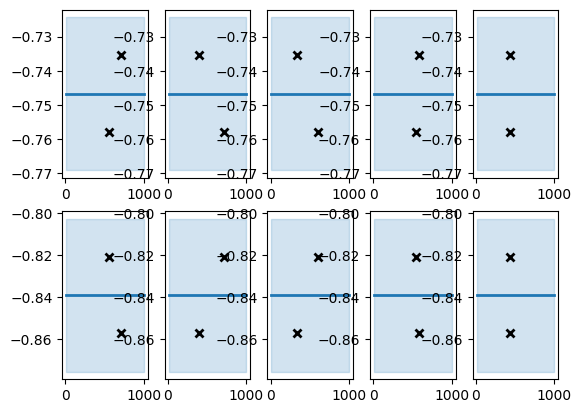

C = [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
Epoch 1/6
1210/1210 [==============================] - 5s 3ms/step - loss: 0.5885 - val_loss: 0.5114
Epoch 2/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5313 - val_loss: 0.5097
Epoch 3/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5285 - val_loss: 0.5392
Epoch 4/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5240 - val_loss: 0.4994
Epoch 5/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5252 - val_loss: 0.5229
Epoch 6/6
135/135 [==============================] - 0s 852us/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]]
New x =  [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
Iteration= 1  x_best= [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119] y= (-0.7269517457826599, -0.86145978614597

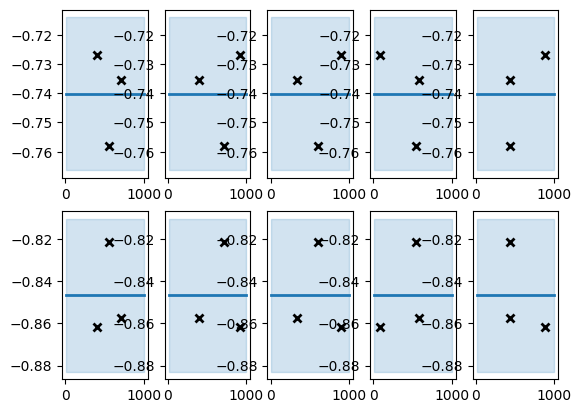

C = [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
Epoch 1/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.5916 - val_loss: 0.5250
Epoch 2/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.5406 - val_loss: 0.5283
Epoch 3/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.5370 - val_loss: 0.5058
Epoch 4/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.5356 - val_loss: 0.5048
Epoch 5/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.5344 - val_loss: 0.5120
Epoch 6/6
135/135 [==============================] - 0s 842us/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]]
New x =  [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
Iteration= 2  x_best= [769.98913882 865.26040386 584.03410952 8

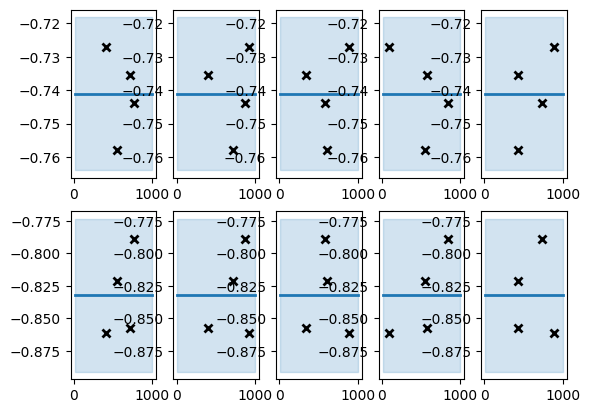

C = [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
Epoch 1/6
1210/1210 [==============================] - 2s 946us/step - loss: 0.5924 - val_loss: 0.5222
Epoch 2/6
1210/1210 [==============================] - 1s 884us/step - loss: 0.5202 - val_loss: 0.5247
Epoch 3/6
1210/1210 [==============================] - 1s 892us/step - loss: 0.5122 - val_loss: 0.5377
Epoch 4/6
1210/1210 [==============================] - 1s 946us/step - loss: 0.5118 - val_loss: 0.5363
Epoch 5/6
1210/1210 [==============================] - 1s 898us/step - loss: 0.5106 - val_loss: 0.5105
Epoch 6/6
135/135 [==============================] - 0s 569us/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]]
New x =  [ 21.9881439  927.25006443 118.10737805 764.18539359

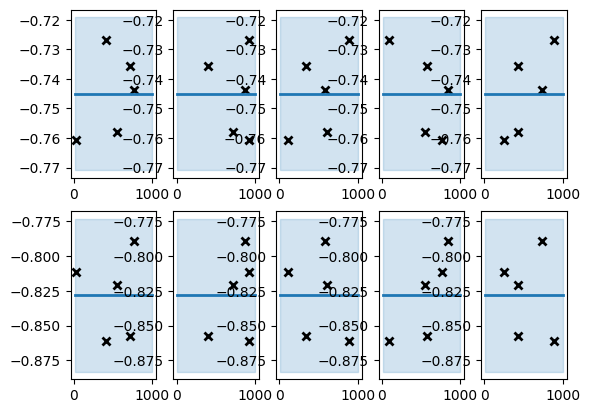

C = [803.18270374 532.24962093 360.92678418 195.4003316  689.57939344]
Epoch 1/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5524 - val_loss: 0.4910
Epoch 2/6
1210/1210 [==============================] - 6s 5ms/step - loss: 0.5172 - val_loss: 0.5042
Epoch 3/6
1210/1210 [==============================] - 6s 5ms/step - loss: 0.5143 - val_loss: 0.5189
Epoch 4/6
1210/1210 [==============================] - 6s 5ms/step - loss: 0.5096 - val_loss: 0.4859
Epoch 5/6
1210/1210 [==============================] - 6s 5ms/step - loss: 0.5053 - val_loss: 0.4816
Epoch 6/6
135/135 [==============================] - 0s 2ms/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]]
New x

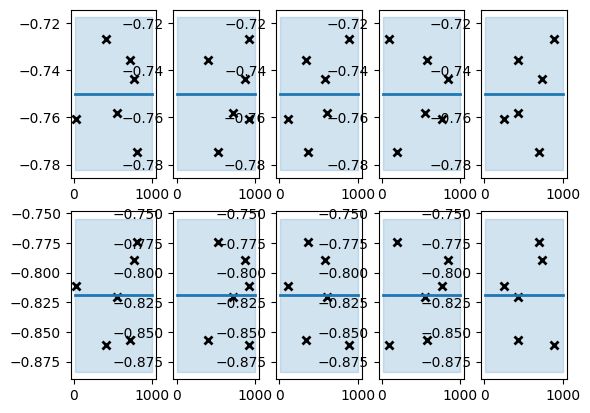

C = [324.37289031 299.10776398 845.56949668 868.93799664 190.01181985]
Epoch 1/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5404 - val_loss: 0.5106
Epoch 2/6
1210/1210 [==============================] - 3s 3ms/step - loss: 0.5040 - val_loss: 0.4967
Epoch 3/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.5011 - val_loss: 0.4783
Epoch 4/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.4988 - val_loss: 0.4785
Epoch 5/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.4994 - val_loss: 0.4971
Epoch 6/6
135/135 [==============================] - 0s 1ms/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
 [803.

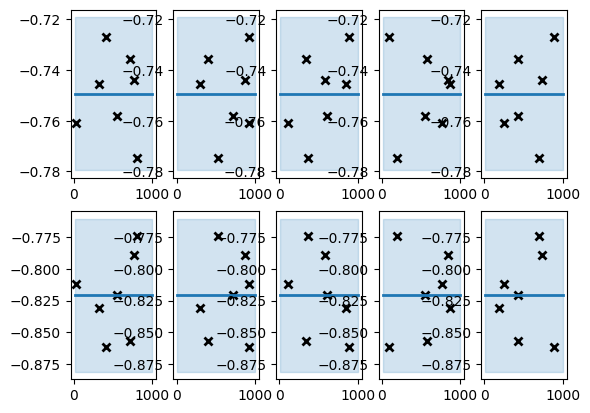

C = [527.6591499  381.73216946 215.29360785 442.67499285 250.61737569]
Epoch 1/6
1210/1210 [==============================] - 3s 2ms/step - loss: 0.5345 - val_loss: 0.4827
Epoch 2/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5063 - val_loss: 0.4846
Epoch 3/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5023 - val_loss: 0.4861
Epoch 4/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5004 - val_loss: 0.4805
Epoch 5/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.4996 - val_loss: 0.4873
Epoch 6/6
135/135 [==============================] - 0s 1ms/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
 [803.

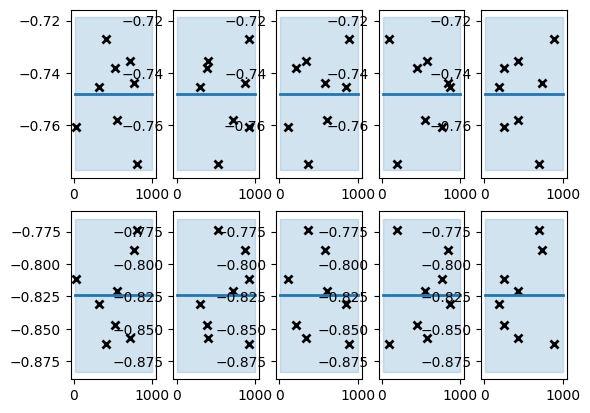

C = [309.46296246 325.5097901  736.1250287  422.23528836 604.36539395]
Epoch 1/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5458 - val_loss: 0.5224
Epoch 2/6
1210/1210 [==============================] - 3s 3ms/step - loss: 0.5129 - val_loss: 0.4837
Epoch 3/6
1210/1210 [==============================] - 3s 3ms/step - loss: 0.5095 - val_loss: 0.4935
Epoch 4/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.5061 - val_loss: 0.4878
Epoch 5/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.5022 - val_loss: 0.5157
Epoch 6/6
135/135 [==============================] - 0s 2ms/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
 [803.

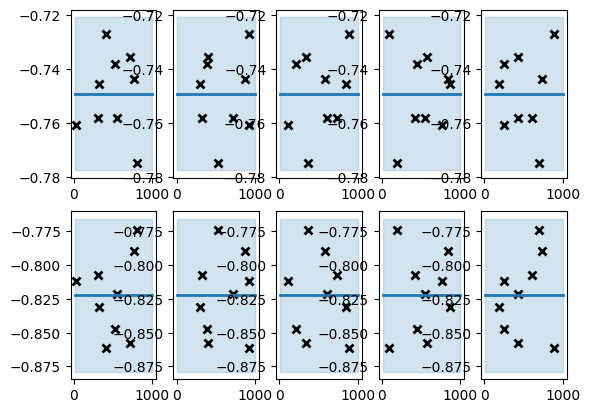

C = [873.64390722 336.81119115 538.5995203  191.81366128 461.62919347]
Epoch 1/6
1210/1210 [==============================] - 9s 7ms/step - loss: 0.5397 - val_loss: 0.4839
Epoch 2/6
1210/1210 [==============================] - 6s 5ms/step - loss: 0.5076 - val_loss: 0.4828
Epoch 3/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.5046 - val_loss: 0.4894
Epoch 4/6
1210/1210 [==============================] - 6s 5ms/step - loss: 0.5035 - val_loss: 0.4891
Epoch 5/6
1210/1210 [==============================] - 7s 6ms/step - loss: 0.5013 - val_loss: 0.4822
Epoch 6/6
135/135 [==============================] - 0s 2ms/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
 [803.

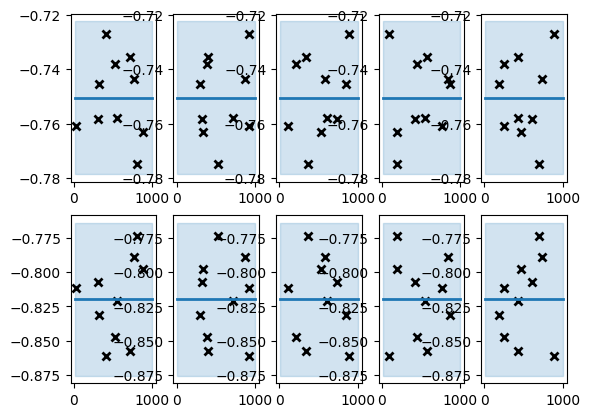

C = [917.48088887 887.17156835 830.6792557  773.06768942 369.92324042]
Epoch 1/6
1210/1210 [==============================] - 11s 8ms/step - loss: 0.5615 - val_loss: 0.5178
Epoch 2/6
1210/1210 [==============================] - 8s 7ms/step - loss: 0.5254 - val_loss: 0.4977
Epoch 3/6
1210/1210 [==============================] - 9s 7ms/step - loss: 0.5216 - val_loss: 0.4978
Epoch 4/6
1210/1210 [==============================] - 9s 7ms/step - loss: 0.5177 - val_loss: 0.4921
Epoch 5/6
1210/1210 [==============================] - 9s 7ms/step - loss: 0.5166 - val_loss: 0.5269
Epoch 6/6
135/135 [==============================] - 0s 1ms/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
 [803

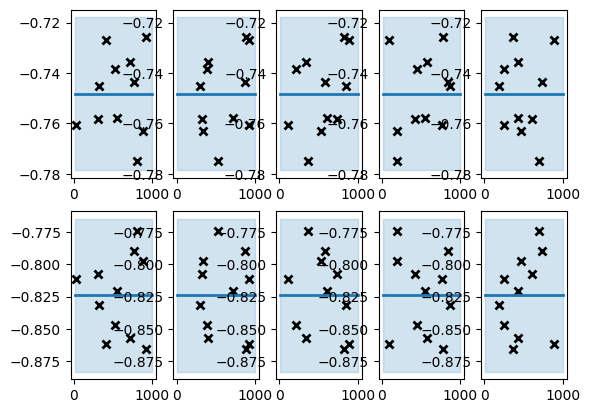

C = [955.8623654  977.56264101  32.43104848 634.55180789  96.58167032]
Epoch 1/6
1210/1210 [==============================] - 4s 2ms/step - loss: 0.5536 - val_loss: 0.4891
Epoch 2/6
1210/1210 [==============================] - 3s 2ms/step - loss: 0.5142 - val_loss: 0.4893
Epoch 3/6
1210/1210 [==============================] - 3s 2ms/step - loss: 0.5107 - val_loss: 0.4882
Epoch 4/6
1210/1210 [==============================] - 3s 2ms/step - loss: 0.5082 - val_loss: 0.4878
Epoch 5/6
1210/1210 [==============================] - 3s 2ms/step - loss: 0.5050 - val_loss: 0.4872
Epoch 6/6
135/135 [==============================] - 0s 613us/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
 [80

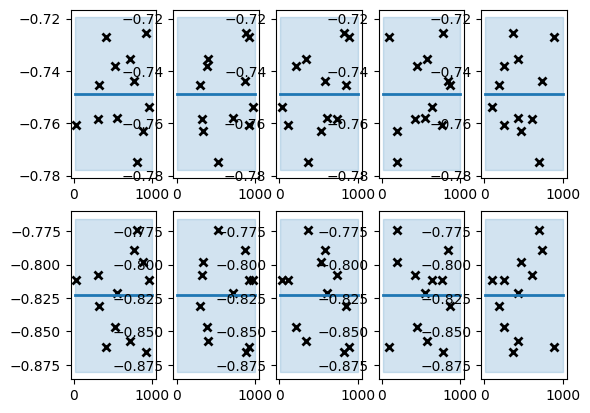

C = [384.75669849  78.74801159 136.84799316  19.53345659 734.69048452]
Epoch 1/6
1210/1210 [==============================] - 2s 1ms/step - loss: 0.5241 - val_loss: 0.5029
Epoch 2/6
1210/1210 [==============================] - 2s 1ms/step - loss: 0.5030 - val_loss: 0.4823
Epoch 3/6
1210/1210 [==============================] - 2s 1ms/step - loss: 0.5003 - val_loss: 0.4870
Epoch 4/6
1210/1210 [==============================] - 2s 1ms/step - loss: 0.4969 - val_loss: 0.4817
Epoch 5/6
1210/1210 [==============================] - 2s 1ms/step - loss: 0.4968 - val_loss: 0.4852
Epoch 6/6
135/135 [==============================] - 0s 668us/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
 [80

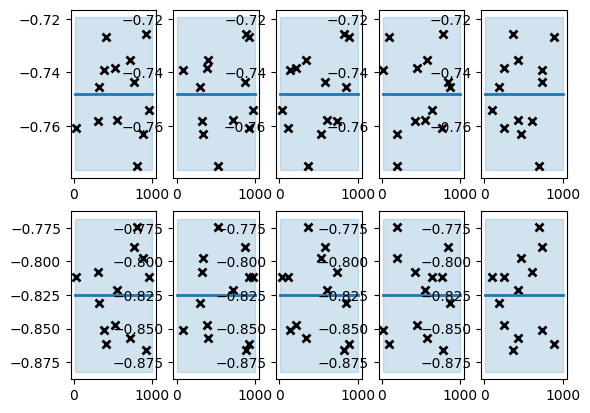

C = [593.10358187 665.41048458 384.89289281 809.06454503 838.96787285]
Epoch 1/6
1210/1210 [==============================] - 3s 2ms/step - loss: 0.5735 - val_loss: 0.4901
Epoch 2/6
1210/1210 [==============================] - 3s 3ms/step - loss: 0.5299 - val_loss: 0.4892
Epoch 3/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5321 - val_loss: 0.5330
Epoch 4/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5324 - val_loss: 0.5000
Epoch 5/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5265 - val_loss: 0.4987
Epoch 6/6
135/135 [==============================] - 0s 1ms/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
 [803.

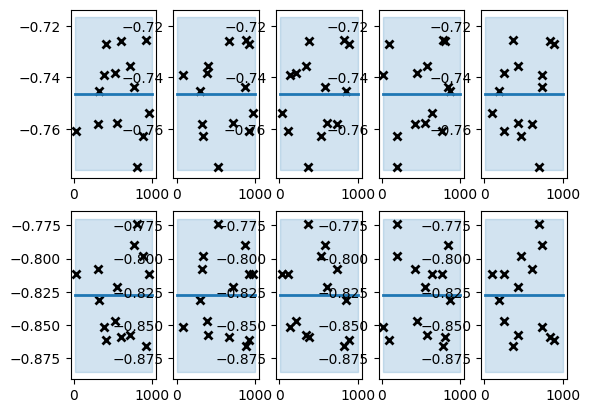

C = [569.39812573 806.65829306 973.53747173 447.071657   962.88995566]
Epoch 1/6
1210/1210 [==============================] - 7s 5ms/step - loss: 0.5930 - val_loss: 0.5198
Epoch 2/6
1210/1210 [==============================] - 7s 6ms/step - loss: 0.5352 - val_loss: 0.5097
Epoch 3/6
1210/1210 [==============================] - 7s 6ms/step - loss: 0.5304 - val_loss: 0.5160
Epoch 4/6
1210/1210 [==============================] - 7s 6ms/step - loss: 0.5291 - val_loss: 0.5185
Epoch 5/6
1210/1210 [==============================] - 7s 6ms/step - loss: 0.5276 - val_loss: 0.4939
Epoch 6/6
135/135 [==============================] - 0s 1ms/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
 [803.

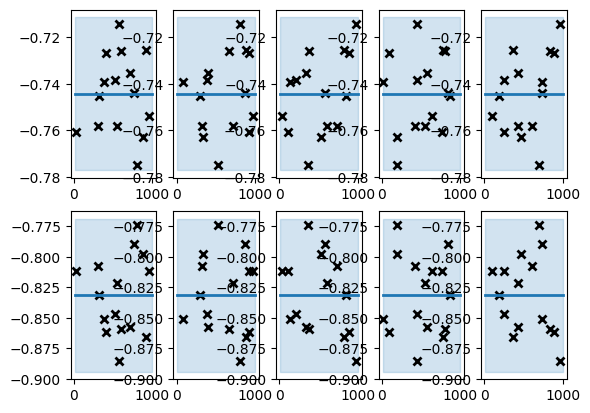

C = [344.15195868 425.79802493 562.69953136 804.13721115 394.40988513]
Epoch 1/6
1210/1210 [==============================] - 5s 3ms/step - loss: 0.5424 - val_loss: 0.5128
Epoch 2/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5137 - val_loss: 0.4979
Epoch 3/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5094 - val_loss: 0.5113
Epoch 4/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5098 - val_loss: 0.4844
Epoch 5/6
1210/1210 [==============================] - 4s 3ms/step - loss: 0.5074 - val_loss: 0.4949
Epoch 6/6
135/135 [==============================] - 0s 750us/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
 [80

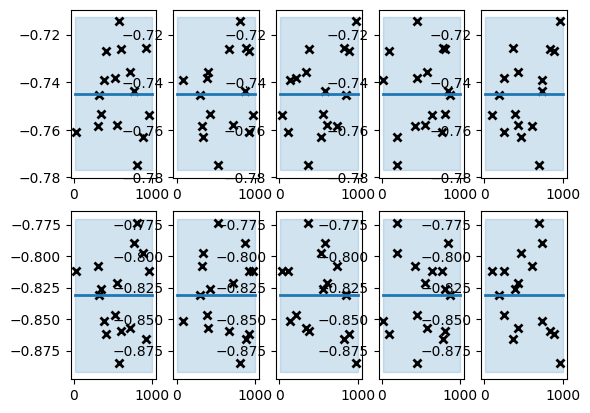

C = [500.127824   815.98826448 999.34535242 459.33224238 446.64316232]
Epoch 1/6
1210/1210 [==============================] - 6s 4ms/step - loss: 0.5733 - val_loss: 0.5038
Epoch 2/6
1210/1210 [==============================] - 5s 5ms/step - loss: 0.5235 - val_loss: 0.5102
Epoch 3/6
1210/1210 [==============================] - 6s 5ms/step - loss: 0.5185 - val_loss: 0.5140
Epoch 4/6
1210/1210 [==============================] - 6s 5ms/step - loss: 0.5144 - val_loss: 0.5105
Epoch 5/6
1210/1210 [==============================] - 8s 6ms/step - loss: 0.5133 - val_loss: 0.5207
Epoch 6/6
135/135 [==============================] - 0s 2ms/step
Current x =  [[553.32536889 718.03747271 606.73574231 549.43435117 429.41825135]
 [714.28183258 401.48329265 335.44416645 580.82245523 431.21757108]
 [403.41803631 918.26290549 894.98288053  88.5033236  882.22370119]
 [769.98913882 865.26040386 584.03410952 842.04825848 727.45910009]
 [ 21.9881439  927.25006443 118.10737805 764.18539359 255.34487721]
 [803.

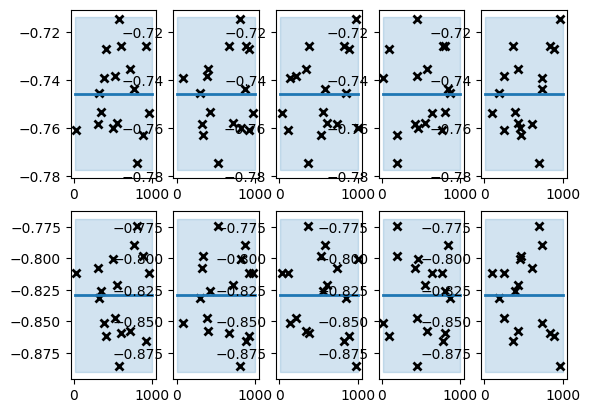

C = [814.83400047 421.019175   660.6366951  937.74669108 631.59342846]
Epoch 1/6
1210/1210 [==============================] - 7s 5ms/step - loss: 0.5604 - val_loss: 0.4919
Epoch 2/6
1036/1210 [========================>.....] - ETA: 0s - loss: 0.5223

In [ ]:
savename = "MOONNHeart"

### GPs Initialization
GP = GaussianProcess(O, C, d, lowerBounds, upperBounds, noise_variance=2e-6)

#### Initial samples, at least 1
for l in range(initial_iter):
    ## Get random evaluation point
    while True:
        x_rand = np.random.uniform(lowerBounds[0], upperBounds[0], d)
        if GP.X is None or not x_rand in GP.X:
            break
    ## EVALUATION OF THE OUTSIDE FUNCTION
    
    y_rand = evaluation(x_rand)
    GP.X = np.array([x_rand], dtype=float)
    GP.Y = np.array([y_rand], dtype=float)

GP.updateGP()
GP.optimizeKernel()
if False:
    GP.plotSamples()

for l in range(total_iter):

    ## For all acq functions but usemo
    #x_best, acq_best = mes_acq(GP)
    ## For usemo
    x_best, acq_best = usemo_acq(GP, function = "ei", showplots = False)

    ## EVALUATION OF THE OUTSIDE FUNCTION
    y_best = evaluation(x_best)

    ## UPDATE
    GP.addSample(x_best,y_best)     ## Add new sample to the model
    GP.updateGP()                   ## Update data on the GP regressor
    GP.optimizeKernel()             ## Optimize kernel hyperparameters

    print("Iteration=", l, " x_best=", x_best, "y=", y_best)
    GP.plot()
    

## Evaluate results

As you are doing a real world experiment you do not have access to the real pareto front, then you fo noy hsbr yhr metrics as before (I removed them).

What you should evaluate is the results in terms of the best *y* possible. You have the data below, but you may do a pandas dataframe to store it cleaner when it is computed in the previous section.

GP.X === samples where the function was evaluated

GP.Y === results of those evaluations

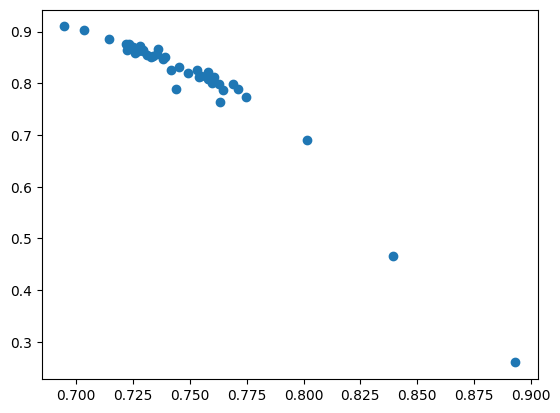

In [10]:
plt.scatter(-GP.Y[:,0],-GP.Y[:,1])

In [11]:
-GP.Y

array([[0.75793991, 0.82101348],
       [0.73554049, 0.85727569],
       [0.72695175, 0.86145979],
       [0.74375821, 0.78940028],
       [0.76078431, 0.81171548],
       [0.77477897, 0.77405858],
       [0.74531055, 0.83124128],
       [0.73824959, 0.84704788],
       [0.7581842 , 0.80753138],
       [0.76300578, 0.79776848],
       [0.72564302, 0.86564389],
       [0.75388601, 0.81171548],
       [0.73920065, 0.85123199],
       [0.72584446, 0.85913529],
       [0.71444653, 0.88516969],
       [0.75328529, 0.82612738],
       [0.75992939, 0.80055788],
       [0.76912752, 0.79916318],
       [0.83946488, 0.46675965],
       [0.72508724, 0.86936309],
       [0.89314195, 0.26034403],
       [0.72923197, 0.86517899],
       [0.73596838, 0.86564389],
       [0.72808379, 0.87261739],
       [0.72173246, 0.87540679],
       [0.77111717, 0.78940028],
       [0.72250291, 0.86424919],
       [0.73287946, 0.85076709],
       [0.70358306, 0.90376569],
       [0.7336    , 0.85262669],
       [0.

In [ ]:
from utils.calc_pareto import get_pareto_undominated_by

front = get_pareto_undominated_by(results)


plt.scatter(-front[:,0],-front[:,1])

In [ ]:
-results

In [ ]:
x_front = [GP.X[(-GP.Y).tolist().index(y)] for y in front.tolist()]

In [ ]:
!mkdir Checkpoints

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

front_test = []

data = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv")
X = data.drop("HeartDiseaseorAttack", axis=1)
y = data["HeartDiseaseorAttack"]

y_1 = y[y == 1]
y_used = pd.concat([y_1, y[y == 0].sample(len(y_1))])
X_used = X.iloc[y_used.index]

X_train_val, X_test, y_train_val, y_test = train_test_split(X_used, y_used, test_size=0.1, random_state=42, stratify=y_used)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val)


for arch in x_front:
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(21, 1)),
      tf.keras.layers.Dense(int(np.around(arch[0])), activation='relu'),
      tf.keras.layers.Dense(int(np.around(arch[1])), activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    checkpoint_path = f"./Checkpoints/model_{int(np.around(arch[0]))}_{int(np.around(arch[1]))}"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    
    model.load_weights(checkpoint_path)
    
    y_pred = np.around(model.predict(X_test))
    
    front_test.append((precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
    

In [ ]:
[x[0] for x in front_test]

plt.scatter([x[0] for x in front_test], [x[1] for x in front_test])

In [ ]:
front_test

In [ ]:
#!rm -rf Checkpoints